In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load cleaned data
df = pd.read_csv("data/HR_data_cleaned.csv")

### Physiological data

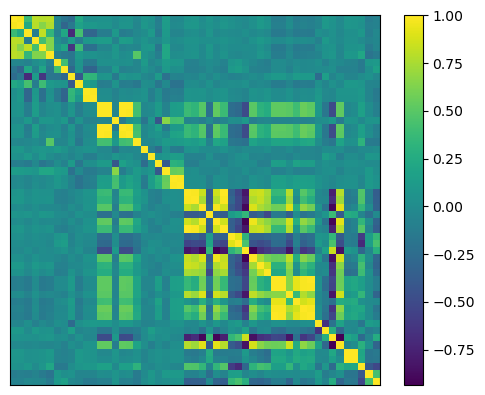

In [2]:
# feature selection by correlation between columns

def select_cols_to_drop(df, corr_cutoff):
    # continuous columns
    continuous_cols = df.columns[0:51]

    # absolute value of correlation matrix
    corr_matrix = df[continuous_cols].corr().abs()

    # upper triangular array of True booleans
    bool_array = np.ones(corr_matrix.shape).astype(bool)
    T = np.triu(bool_array, 1)

    T_corr_matrix = corr_matrix.where(T)

    # array of columns to drop
    drop_cols = []

    # drop columns that have at least corr_cutoff absolute correlation with at least one other column
    for col in T_corr_matrix.columns:
        if any(T_corr_matrix[col] > corr_cutoff):
            drop_cols.append(col)
    
    return drop_cols

# plot absolute value correlation matrix (without taking absolute value first)
continuous_cols = df.columns[0:51]
plt.imshow(df[continuous_cols].corr())
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [3]:
# select features to use for clustering

drop_cols = select_cols_to_drop(df, corr_cutoff=0.9)
print(f"Number of columns to drop: {len(drop_cols)}")

cluster_cols = df[continuous_cols].drop(columns=drop_cols).columns
print(f"Number of columns to use for clustering: {len(cluster_cols)}")
print(f"Columns: {cluster_cols}")

cluster_df =df[cluster_cols]

Number of columns to drop: 19
Number of columns to use for clustering: 32
Columns: Index(['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max', 'HR_TD_AUC',
       'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min', 'HR_TD_Slope_max',
       'HR_TD_Slope_mean', 'TEMP_TD_Mean', 'TEMP_TD_std', 'TEMP_TD_AUC',
       'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'EDA_TD_P_Mean',
       'EDA_TD_P_std', 'EDA_TD_P_Min', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_std', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_mean', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT'],
      dtype='object')


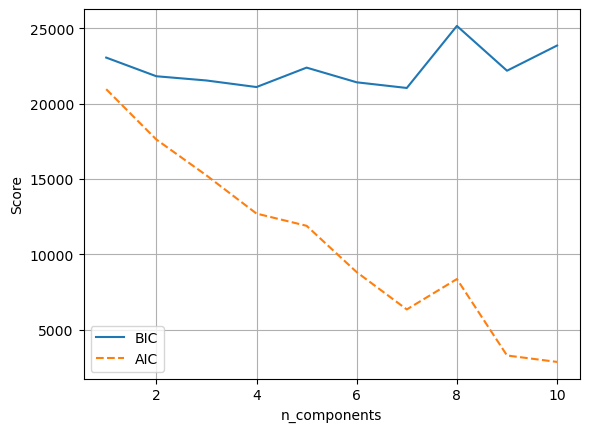

In [4]:
n_components = np.arange(1, 11) #n components to try
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster_df)
          for n in n_components]

plt.plot(n_components, [m.bic(cluster_df) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cluster_df) for m in models], label='AIC', linestyle="dashed")
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.grid(True)
plt.savefig("results/AIC_BIC.pdf")
plt.show()

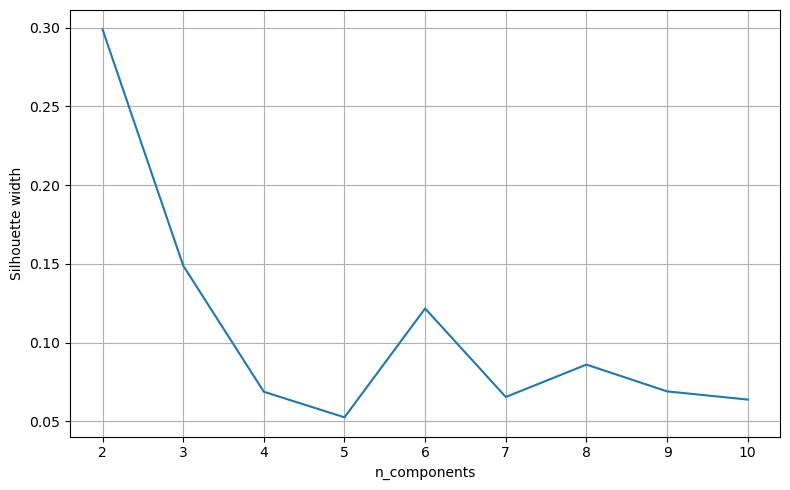

In [5]:
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    labels = gmm.fit_predict(cluster_df)
    score = silhouette_score(cluster_df, labels)
    silhouette_scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores)
plt.xlabel('n_components')
plt.ylabel('Silhouette width')
plt.grid(True)
plt.tight_layout()
plt.show()

# GMM

In [6]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm_labels = gmm.fit_predict(cluster_df)
df['gmm_cluster'] = gmm_labels + 1

In [7]:
gmm.means_

array([[ 0.25918354,  0.00947821,  0.24030434,  0.14594758,  0.20671733,
        -0.14707322, -0.18134672, -0.16861716, -0.02227151,  0.16959266,
         1.14029045, -0.0350029 ,  0.49789407,  0.12175574, -0.33699545,
        -0.46124524,  0.09429694,  0.10963057,  3.28884859,  3.07333145,
        -1.31087977, -0.97714019,  3.31117907,  2.97831106,  1.42227418,
         2.7976558 ,  0.05641236, -0.41493317, -0.92060706,  1.30372796,
        -0.04225149, -0.93168576],
       [-0.07213667, -0.26042984,  0.04422662, -0.2192877 ,  0.13988718,
        -0.0283951 , -0.27044827,  0.30363021, -0.13222217,  0.292556  ,
         0.51826412, -0.14485181,  0.5415058 , -0.11858835, -0.08566966,
         0.33306495, -0.11545046,  0.09231897,  0.06019847,  0.28472378,
         0.02137063, -0.52304694, -0.00870815, -0.02100479,  0.45561285,
         0.32113647,  0.13576172, -0.27836154,  0.43144768,  0.55907388,
        -0.30099571, -0.50496423],
       [ 1.00227567,  1.24545112,  0.37766102,  1.3505

# Visualize

In [8]:
summary = df.groupby('gmm_cluster')[[
    'Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired',
    'nervous', 'attentive', 'afraid', 'active', 'determined'
]].mean().round(2)

display(summary)


,Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
gmm_cluster,,,,,,,,,,,
1,1.68,1.26,1.11,1.74,1.32,1.47,1.16,2.11,1.05,2.00,2.32
2,2.24,1.47,1.12,2.26,1.31,2.25,1.48,2.96,1.03,2.71,2.96
3,1.82,1.24,1.02,2.50,1.14,2.58,1.32,2.98,1.05,2.82,3.29
4,2.02,1.32,1.03,2.06,1.19,2.04,1.38,2.67,1.07,2.39,2.79


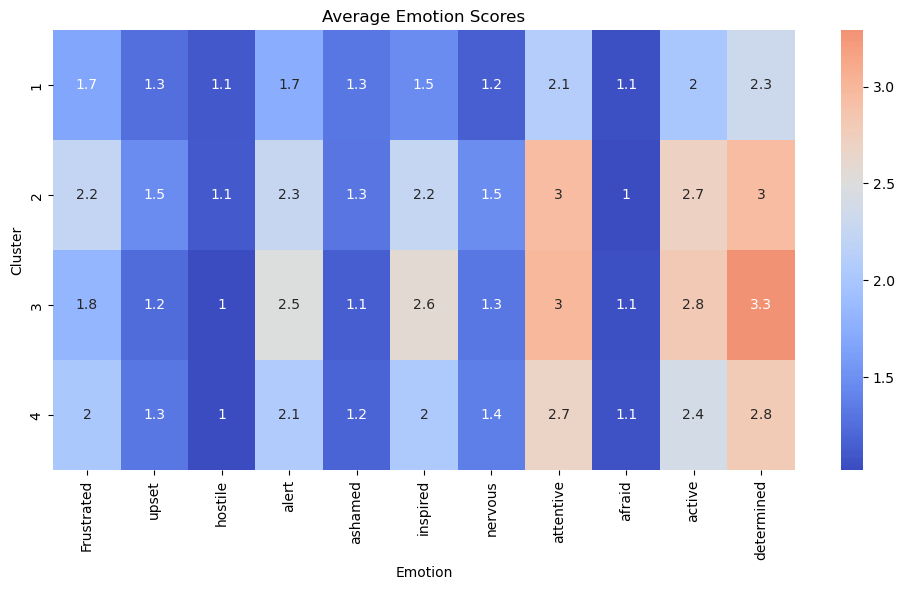

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(summary, annot=True, cmap="coolwarm", center=2.5)
plt.title("Average Emotion Scores")
plt.xlabel("Emotion")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


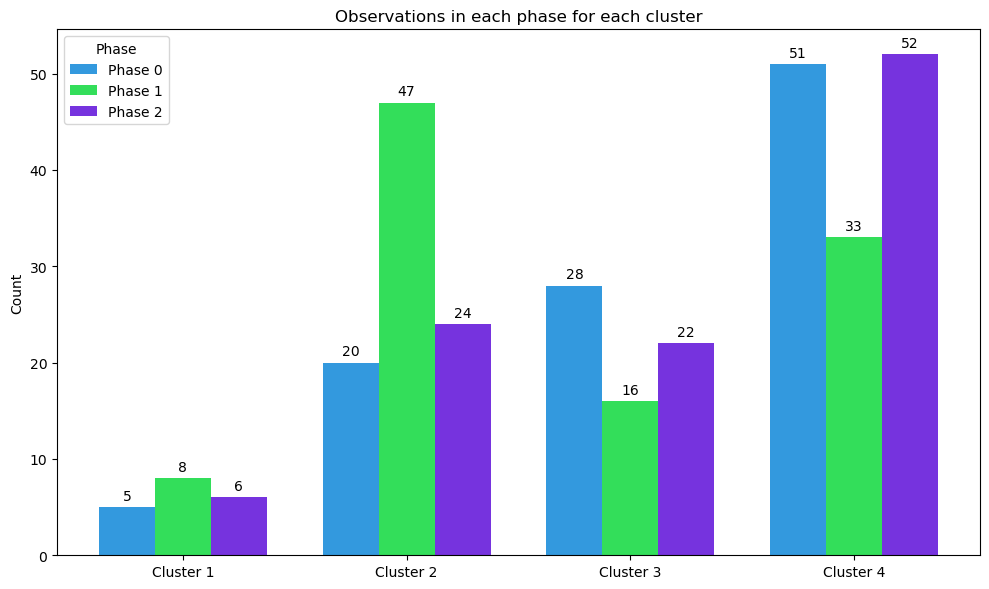

In [37]:
num_clusters = len(np.unique(gmm_labels))

phases = [0, 1, 2]  # integer phase labels
colors = ["#3399de", "#33de5a", "#7633de"]
phase_labels = ["Phase 0", "Phase 1", "Phase 2"]

counts = []
for phase in phases:
    phase_mask = df["Phase"] == phase
    cluster_counts = df[phase_mask]['gmm_cluster'].value_counts().sort_index()

    complete_counts = [cluster_counts.get(i+1, 0) for i in range(num_clusters)]
    counts.append(complete_counts)

tick_space = np.arange(num_clusters)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i, phase_count in enumerate(counts):
    offset = width * i
    rects = ax.bar(tick_space + offset, phase_count, width, label=phase_labels[i], color=colors[i])
    ax.bar_label(rects, padding=3)

ax.set_xticks(tick_space + width, [f"Cluster {i+1}" for i in range(num_clusters)])
ax.set_ylabel("Count")
ax.set_title("Observations in each phase for each cluster")
ax.legend(title="Phase")
plt.tight_layout()
plt.show()


# Positive / Negative emotions

             positive_total  negative_total
gmm_cluster                                
1                  1.926316        1.263158
2                  2.628571        1.443223
3                  2.833333        1.262626
4                  2.389706        1.334559


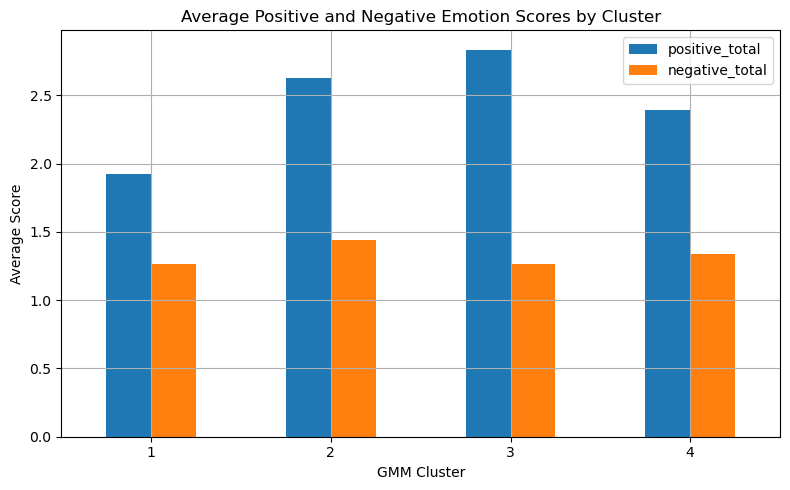

In [16]:
positive_emotions = ['alert', 'inspired', 'attentive', 'active', 'determined']
negative_emotions = ['Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid']

df['positive_total'] = df[positive_emotions].mean(axis=1)
df['negative_total'] = df[negative_emotions].mean(axis=1)

cluster_summary = df.groupby('gmm_cluster')[['positive_total', 'negative_total']].mean()
print(cluster_summary)


# Bar plot to compare average emotion scores per cluster
cluster_summary.plot(kind='bar', figsize=(8, 5))
plt.title('Average Positive and Negative Emotion Scores by Cluster')
plt.xlabel('GMM Cluster')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Puzzler vs Individual

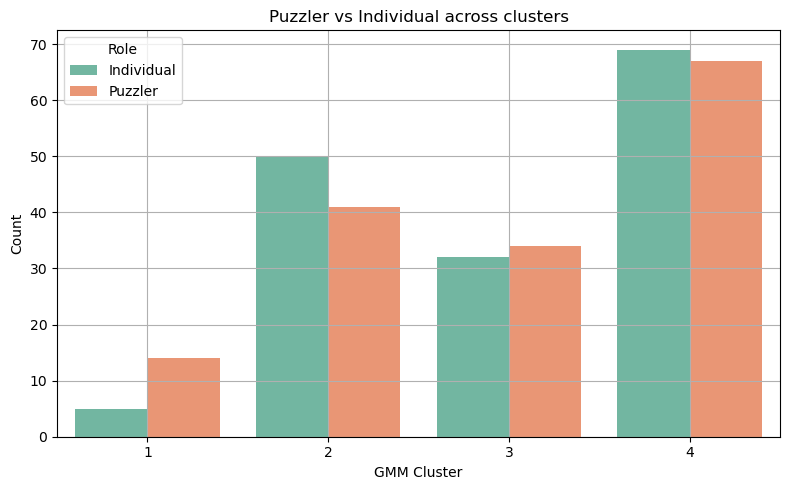

In [17]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gmm_cluster', hue='Puzzler', palette='Set2')
plt.title('Puzzler vs Individual across clusters')
plt.xlabel('GMM Cluster')
plt.ylabel('Count')
plt.legend(title='Role', labels=['Individual', 'Puzzler'])
plt.grid(True)
plt.tight_layout()
plt.show()


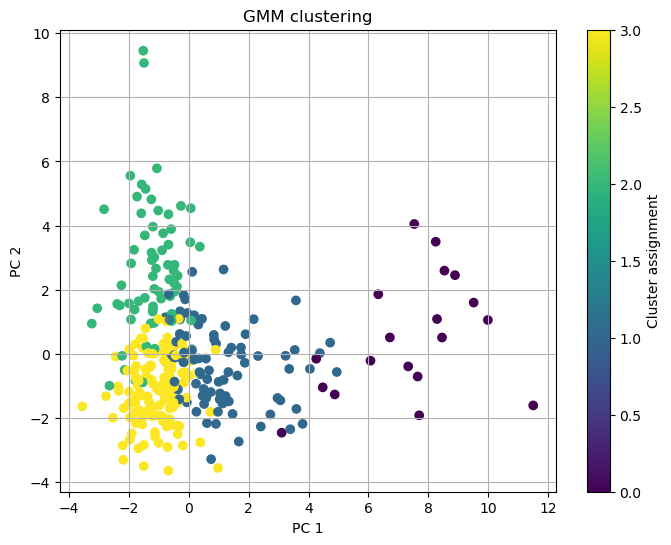

In [18]:


probs = gmm.predict_proba(cluster_df)
labels = probs.argmax(axis=1)
confidences = probs.max(axis=1)

pca = PCA(n_components=2)
X = pca.fit_transform(cluster_df)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=confidences)
plt.colorbar(label='Cluster assignment')
plt.title('GMM clustering')  #opacity = confidence
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()


### Emotional data

In [19]:
emotion_cols = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired',
                'nervous', 'attentive', 'afraid', 'active', 'determined']
df_emotions = df[emotion_cols]

#scale data
df_emotions_scaled = StandardScaler().fit_transform(df_emotions)

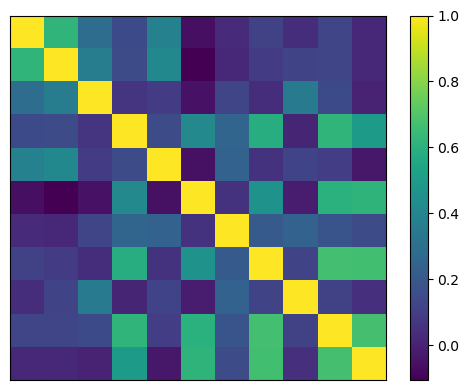

In [20]:
plt.figure(figsize=(5, 4))
plt.imshow(df[emotion_cols].corr(),  aspect='auto')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

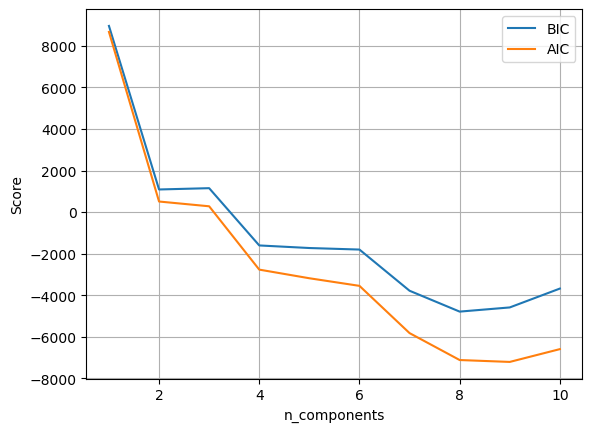

In [21]:
n_components = np.arange(1, 11) #n components to try
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df_emotions_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(df_emotions_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df_emotions_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [22]:
gmm2 = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm_labels_emotional = gmm2.fit_predict(df_emotions_scaled)
df['gmm_cluster_emotional'] = gmm_labels_emotional + 1

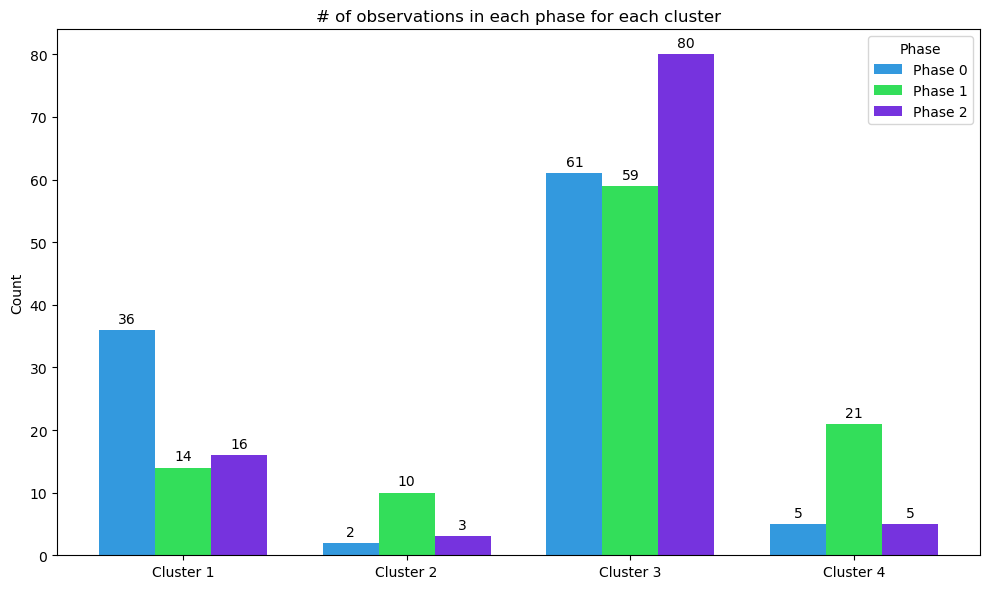

In [36]:
num_clusters = len(np.unique(gmm_labels_emotional))

phases = [0, 1, 2]  # integer phase labels
colors = ["#3399de", "#33de5a", "#7633de"]
phase_labels = ["Phase 0", "Phase 1", "Phase 2"]

counts = []
for phase in phases:
    phase_mask = df["Phase"] == phase
    cluster_counts = df[phase_mask]['gmm_cluster_emotional'].value_counts().sort_index()

    complete_counts = [cluster_counts.get(i+1, 0) for i in range(num_clusters)]
    counts.append(complete_counts)

tick_space = np.arange(num_clusters)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i, phase_count in enumerate(counts):
    offset = width * i
    rects = ax.bar(tick_space + offset, phase_count, width, label=phase_labels[i], color=colors[i])
    ax.bar_label(rects, padding=3)

ax.set_xticks(tick_space + width, [f"Cluster {i+1}" for i in range(num_clusters)])
ax.set_ylabel("Count")
ax.set_title("# of observations in each phase for each cluster")
ax.legend(title="Phase")
plt.tight_layout()
plt.show()


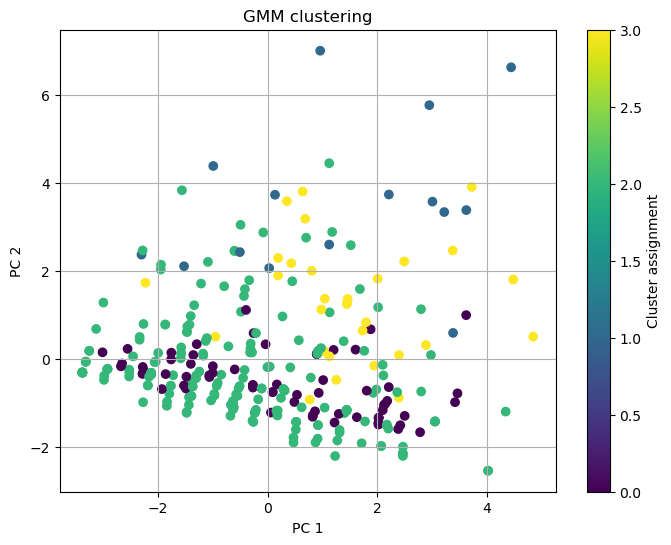

In [24]:
probs = gmm2.predict_proba(df_emotions_scaled)
labels = probs.argmax(axis=1)
confidences = probs.max(axis=1)

pca = PCA(n_components=2)
X = pca.fit_transform(df_emotions_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=confidences)
plt.colorbar(label='Cluster assignment')
plt.title('GMM clustering')  #opacity = confidence
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()


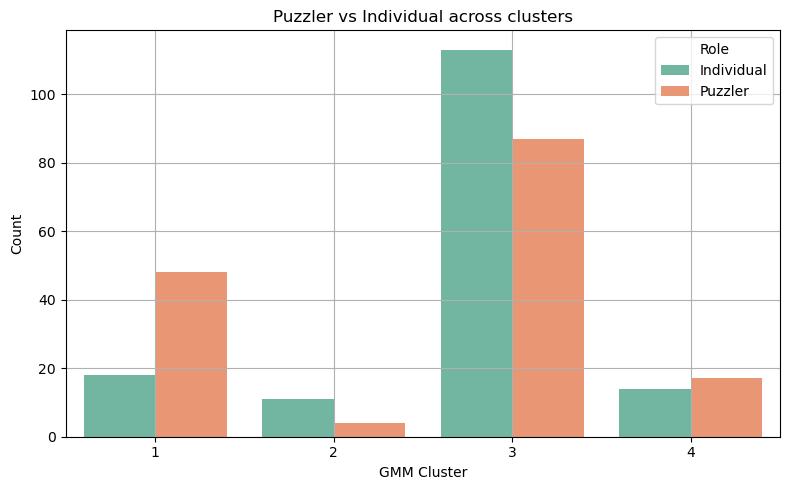

In [25]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gmm_cluster_emotional', hue='Puzzler', palette='Set2')
plt.title('Puzzler vs Individual across clusters')
plt.xlabel('GMM Cluster')
plt.ylabel('Count')
plt.legend(title='Role', labels=['Individual', 'Puzzler'])
plt.grid(True)
plt.tight_layout()
plt.show()


### Using both Physiological and Emotional data

In [26]:
emotion_cols = [
    'Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired',
    'nervous', 'attentive', 'afraid', 'active', 'determined'
]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[emotion_cols] = scaler.fit_transform(df[emotion_cols])

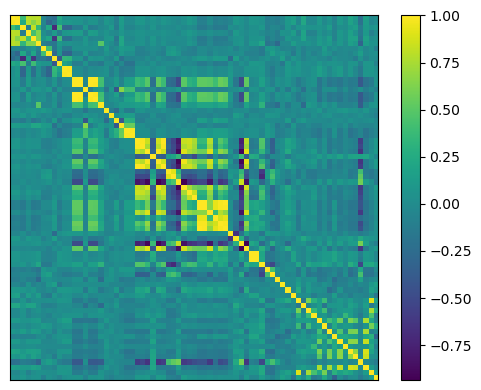

In [27]:
# Plot the correlation matrix of the reduced features
plt.figure(figsize=(5, 4))
plt.imshow(df.corr(),  aspect='auto')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

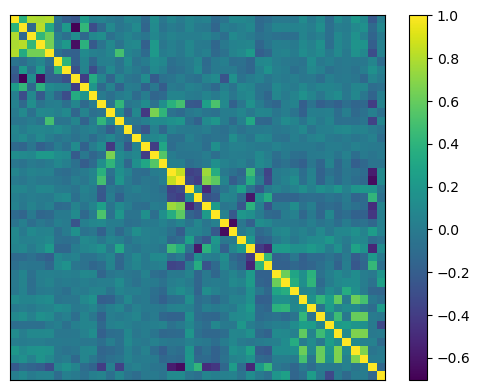

In [28]:
# Redefine function to drop based on correlation within selected features only
def select_cols_to_drop_by_corr(df, corr_cutoff):
    corr_matrix = df.corr().abs()
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    upper_corr_matrix = corr_matrix.where(upper_triangle)

    drop_cols = [
        column for column in upper_corr_matrix.columns
        if any(upper_corr_matrix[column] > corr_cutoff)
    ]
    return drop_cols

# Columns to drop first
drop_cols = [
    'Round','Phase','Cohort','Individual', 'Puzzler'
]

df_cluster_input = df_scaled.drop(columns=drop_cols)

# Select and drop highly correlated columns
corr_based_drop_cols = select_cols_to_drop_by_corr(df_cluster_input, corr_cutoff=0.85)
df_cluster_full = df_cluster_input.drop(columns=corr_based_drop_cols)

# Plot the correlation matrix of the reduced features
plt.figure(figsize=(5, 4))
plt.imshow(df_cluster_full.corr(),  aspect='auto')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [29]:
print(df_cluster_full.keys())
np.size(df_cluster_full.keys())

Index(['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max', 'HR_TD_AUC',
       'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min', 'HR_TD_Slope_max',
       'HR_TD_Slope_mean', 'TEMP_TD_Mean', 'TEMP_TD_std', 'TEMP_TD_AUC',
       'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'EDA_TD_P_Mean',
       'EDA_TD_P_std', 'EDA_TD_P_Min', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Slope',
       'EDA_TD_T_Mean', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_mean', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT',
       'Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired',
       'nervous', 'attentive', 'afraid', 'active', 'determined', 'gmm_cluster',
       'gmm_cluster_emotional'],
      dtype='object')


43

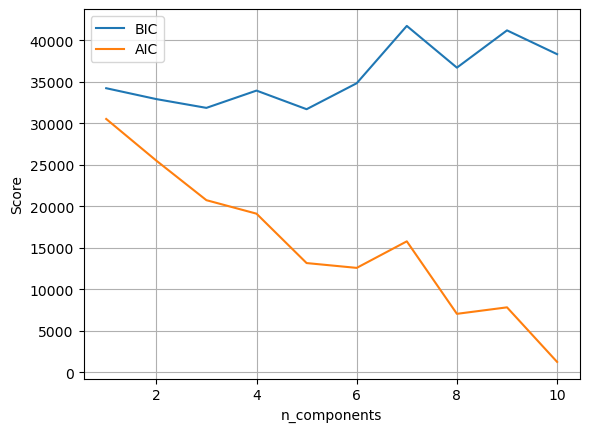

In [30]:
n_components = np.arange(1, 11) #n components to try
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df_cluster_full)
          for n in n_components]

plt.plot(n_components, [m.bic(df_cluster_full) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df_cluster_full) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [31]:
gmm3 = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm_labels_full = gmm3.fit_predict(df_cluster_full)
df['gmm_cluster_full'] = gmm_labels_full + 1

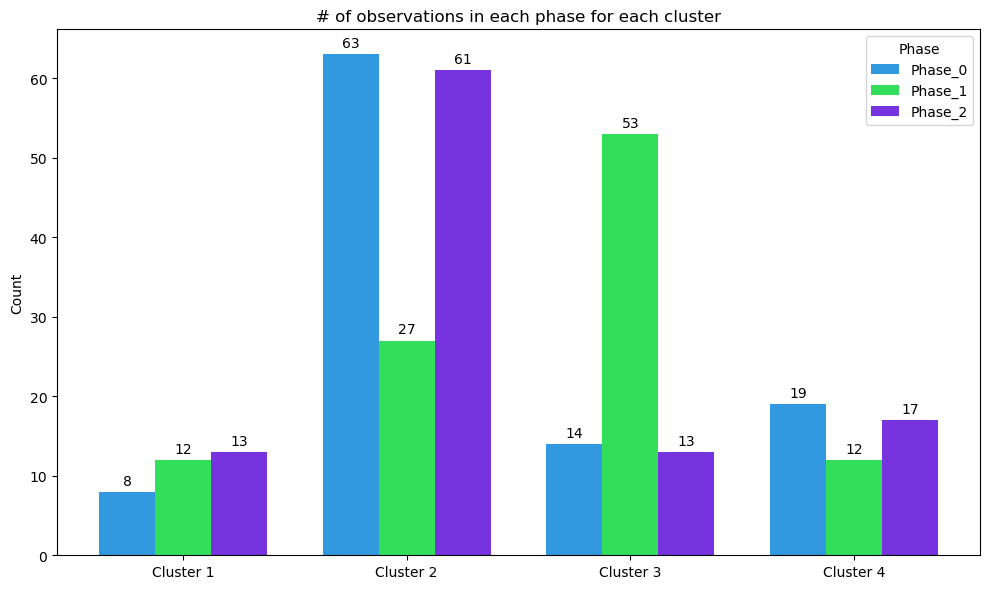

In [33]:
num_clusters = len(np.unique(gmm_labels_full))

phases = [0, 1, 2]  # integer phase labels
colors = ["#3399de", "#33de5a", "#7633de"]
phase_labels = ["Phase_0", "Phase_1", "Phase_2"]  # for the legend

counts = []
for phase in phases:
    phase_mask = df["Phase"] == phase
    cluster_counts = df[phase_mask]['gmm_cluster_full'].value_counts().sort_index()

    complete_counts = [cluster_counts.get(i+1, 0) for i in range(num_clusters)]
    counts.append(complete_counts)

tick_space = np.arange(num_clusters)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i, phase_count in enumerate(counts):
    offset = width * i
    rects = ax.bar(tick_space + offset, phase_count, width, label=phase_labels[i], color=colors[i])
    ax.bar_label(rects, padding=3)

ax.set_xticks(tick_space + width, [f"Cluster {i+1}" for i in range(num_clusters)])
ax.set_ylabel("Count")
ax.set_title("# of observations in each phase for each cluster")
ax.legend(title="Phase")
plt.tight_layout()
plt.show()


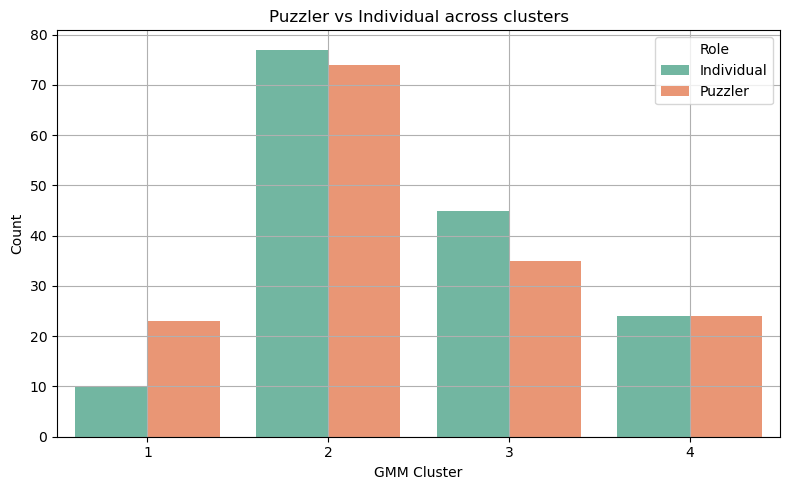

In [34]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gmm_cluster_full', hue='Puzzler', palette='Set2')
plt.title('Puzzler vs Individual across clusters')
plt.xlabel('GMM Cluster')
plt.ylabel('Count')
plt.legend(title='Role', labels=['Individual', 'Puzzler'])
plt.grid(True)
plt.tight_layout()
plt.show()


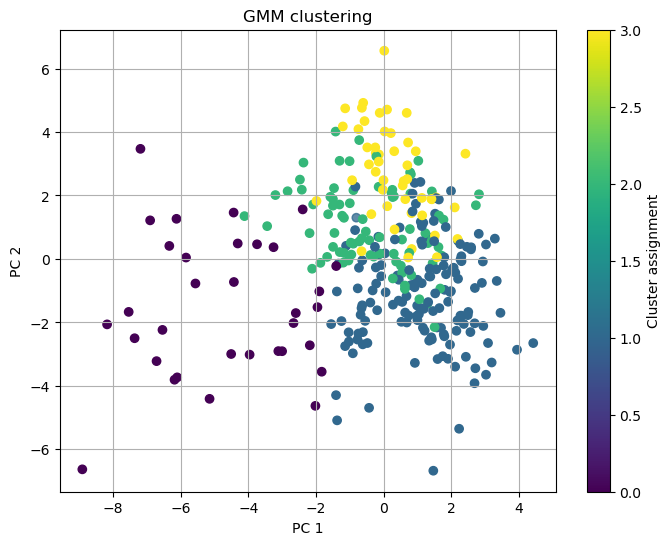

In [35]:

probs = gmm3.predict_proba(df_cluster_full)
labels = probs.argmax(axis=1)
confidences = probs.max(axis=1)

pca = PCA(n_components=2)
X = pca.fit_transform(df_cluster_full)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=confidences)
plt.colorbar(label='Cluster assignment')
plt.title('GMM clustering')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()
